In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [61]:
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow import keras
# from keras.utils.vis_utils import plot_model
# import visualkeras

np.random.seed(1)
tf.random.set_seed(1)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [62]:
# Importamos el dataset que trabajamos en el checkpoint 2 con las varibles categóricas como dummies
reservas = pd.read_csv('/content/sample_data/reservas_dummies.csv')

# Importamos el dataset de test con las variables categóricas como dummies
test = pd.read_csv('/content/sample_data/test_dummies.csv')

In [63]:
# Droppeamos el id para poder entrenar y predecir
ids_train = reservas["id"]
ids_test = test["id"]
reservas.drop(columns="id", inplace=True)
test.drop(columns="id", inplace=True)

# Ordenamos las columnas
reservas = reservas.reindex(sorted(reservas.columns), axis=1)
test = test.reindex(sorted(test.columns), axis=1)

# Imputamos datos faltantes
test['agent'] = test['agent'].fillna(-1)
test['company'] = test['company'].fillna(-1)

In [64]:
def mostrar_metricas(y_test, y_pred):
  #Cantidad de aciertos
  print('correctas: ', np.sum(y_test == y_pred))
  print('total: ', len(y_test))

  print(classification_report(y_test, y_pred))

  #Grafico la matriz de confusión
  tabla=confusion_matrix(y_test, y_pred)
  sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [65]:
def exportar_prediccion(ids_test, y_pred, filename):
  prediccion = pd.DataFrame({"id": ids_test, "is_canceled": y_pred})
  prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

In [66]:
a = reservas.drop(['is_canceled'], axis=1)
b = reservas['is_canceled']

In [67]:
# Normalización Min-Max en los datos de entrenamiento
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(a)

# Balanceo de clases
class_0 = X_train_normalized[b == 0]
class_1 = X_train_normalized[b == 1]

# Balanceo de clases (sobremuestreo de la clase minoritaria)

# Selecciona los ejemplos de la clase mayoritaria (clase "0")
class_0 = X_train_normalized[b == 0]

# Selecciona los ejemplos de la clase minoritaria (clase "1")
class_1 = X_train_normalized[b == 1]

# Realiza sobremuestreo de la clase minoritaria (clase "1")
# - replace=True: Permite muestrear con reemplazo
# - n_samples=len(class_0): Genera tantas muestras de la clase "1" como ejemplos de la clase "0"
class_0_oversampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)

# Combina los datos equilibrados en X_train_balanced y y_train_balanced
# - np.vstack: Apila verticalmente los arrays
# - np.hstack: Concatena horizontalmente los arrays
X_train_balanced = np.vstack((class_0, class_0_oversampled))
y_train_balanced = np.hstack((b[b == 0], np.ones(len(class_0))))

In [68]:
# Datos con normalización y balanceo
x_train_bal, x_test_bal, y_train_bal, y_test_bal = train_test_split(X_train_balanced, y_train_balanced, test_size=0.20, random_state=0)

test_bal  = scaler.transform(test)

In [70]:
cant_clases=len(np.unique(y_train_bal))
d_in=len(a.columns)

modelo_1 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,)),
    keras.layers.Dense(1, activation='sigmoid')])

modelo_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 214       
                                                                 
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
Total params: 216 (864.00 Byte)
Trainable params: 216 (864.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
modelo_1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01),
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['AUC'],
)

cant_epochs_titanic=100
modelo_titanic1_historia = modelo_1.fit(x_train_bal,y_train_bal,
                                                epochs=cant_epochs_titanic,
                                                batch_size=50,verbose=False)

369/369 [==============================] - 2s 5ms/step


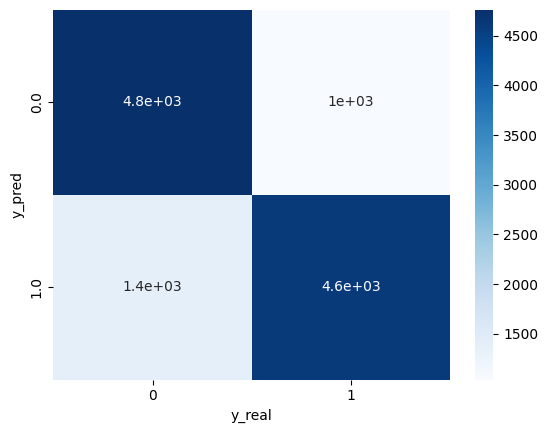

In [83]:
y_predic_ej1 = modelo_1.predict(x_test_bal)
y_predic_cat_ej1 = np.where(y_predic_ej1>0.5,1,0)

ds_validacion=pd.DataFrame(y_predic_cat_ej1,y_test_bal).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [112]:
y_pred_ = modelo_1.predict(test_bal)
y_pred = np.where(y_pred_ > 0.5, 1, 0).astype(int)

830/830 [==============================] - 1s 2ms/step


In [113]:
y_pred = y_pred.reshape(-1)

In [114]:
y_pred

array([1, 0, 0, ..., 1, 1, 0])

In [116]:
exportar_prediccion(ids_test, y_pred, "redes_neuronales_1")